In [1]:
import glob
import Colors
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi

In [2]:
np.random.seed(174612)

In [3]:
g_annotate = ['TBXT','NODAL','CDX2','RSPO3','SOX1','SOX2','WNT3a','FGF8','UNCX','TCF15','ALDH1A2',
            'MESP1','MESP2','RIPPLY2','DPPA5','GATA6','MEOX1','TBX6','CYP26A1','GATA4','HAND1','TBX1','PAX6',
            'ZEB2']

# read data

In [4]:
file = '/Users/anna/Dropbox/gastruloids/data/hGstl-tomo/results_postRevJan19/pooledAll_chichiSB45_normfilt.tsv'
ndf = read_csv(file, sep = '\t', index_col=0)

In [5]:
ndfs_chi = [ndf[[c for c in ndf.columns if g in c]] for g in ['hG01-chi', 'hG02-chi']]
ndfs_sb = [ndf[[c for c in ndf.columns if g in c]] for g in ['hG03-sb', 'hG04-sb']]

In [6]:
file = '/Users/anna/Dropbox/gastruloids/data/hGstl-tomo/results_postRevJan19/geneCorrelations_Chi.tsv'
gene_corr_chi = read_csv(file, sep = '\t', index_col=0)

file = '/Users/anna/Dropbox/gastruloids/data/hGstl-tomo/results_postRevJan19/geneCorrelations_ChiSB43.tsv'
gene_corr_sb = read_csv(file, sep = '\t', index_col=0)

In [7]:
pvth = 0.005
genelist_chi = gene_corr_chi.index[gene_corr_chi['pv']<pvth]

pvth = 0.001
genelist_sb = gene_corr_sb.index[gene_corr_sb['pv']<pvth]
len(genelist_chi), len(genelist_sb)

(1391, 1266)

# z-scores

In [8]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [9]:
zdfs_chi = [zscore(df) for df in ndfs_chi]
zdfs_sb = [zscore(df) for df in ndfs_sb]

# average gastruloids

In [10]:
def averageGastruloid(mzdf,n):
    mdf = mzdf.T
    glds = set(['-'.join(c.rsplit('-')[-2:]) for c in mdf.index])
    mdf['x'] = 0
    for gld in glds:
        idxs = [c for c in mdf.index if gld == '-'.join(c.rsplit('-')[-2:])]
        xra = np.linspace(0,1,len(idxs))
        for idx, x in zip(idxs, xra):
            mdf.loc[idx,'x'] = x
    mdf = mdf.sort_values(by = 'x', ascending = True)
    xdf = pd.DataFrame(columns = mdf.columns, index = range(n))
    xra = np.linspace(0,1,n+1)
    for i in range(len(xra)-1):
        idxs = [c for c in mdf.index if xra[i]<mdf.loc[c,'x']<=xra[i+1]]
        xdf.loc[i] = mdf.loc[idxs].mean()
    del xdf['x']
    return xdf.T

In [11]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [12]:
mzdf_chi = mergeDfs(zdfs_chi)
mzdf_sb = mergeDfs(zdfs_sb)

In [13]:
xdf_chi = averageGastruloid(mzdf_chi, min([len(df.columns) for df in zdfs_chi]))
xdf_sb = averageGastruloid(mzdf_sb, min([len(df.columns) for df in zdfs_sb]))

In [14]:
xdf_chi = xdf_chi.astype(float)
xdf_sb = xdf_sb.astype(float)

In [15]:
tdf_chi = averageGastruloid(mergeDfs(ndfs_chi), min([len(df.columns) for df in zdfs_chi]))
tdf_sb = averageGastruloid(mergeDfs(ndfs_sb), min([len(df.columns) for df in zdfs_sb]))

In [16]:
tdf_chi = tdf_chi.astype(float)
tdf_sb = tdf_sb.astype(float)

# Hox genes in Chi

In [17]:
hoxa14 = []
for letter, number in zip(['A','A','A','A'],[1,2,3,4]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxa14.append(g[0])
    else:
        hoxa14.append('')
print(hoxa14)

['ENSG00000105991_HOXA1__7', 'ENSG00000105996_HOXA2__7', 'ENSG00000105997_HOXA3__7', 'ENSG00000197576_HOXA4__7']


In [18]:
hoxb14 = []
for letter, number in zip(['B']*4,[1,2,3,4]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxb14.append(g[0])
    else:
        hoxb14.append('')
print(hoxb14)

['ENSG00000120094_HOXB1__17', 'ENSG00000173917_HOXB2__17', 'ENSG00000120093_HOXB3__17', 'ENSG00000182742_HOXB4__17']


In [19]:
hoxc14 = []
for letter, number in zip(['C']*4,[1,2,3,4]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxc14.append(g[0])
    else:
        hoxc14.append('')
print(hoxc14)

['', '', '', 'ENSG00000198353_HOXC4__12']


In [20]:
hoxd14 = []
for letter, number in zip(['D']*4,[1,2,3,4]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxd14.append(g[0])
    else:
        hoxd14.append('')
print(hoxd14)

['ENSG00000128645_HOXD1__2', '', 'ENSG00000128652_HOXD3__2', 'ENSG00000170166_HOXD4__2']


In [21]:
hoxa58 = []
for letter, number in zip(['A']*4,[5,6,7,8]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxa58.append(g[0])
    else:
        hoxa58.append('')
print(hoxa58)

hoxb58 = []
for letter, number in zip(['B']*4,[5,6,7,8]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxb58.append(g[0])
    else:
        hoxb58.append('')
print(hoxb58)

hoxc58 = []
for letter, number in zip(['C']*4,[5,6,7,8]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxc58.append(g[0])
    else:
        hoxc58.append('')
print(hoxc58)

hoxd58 = []
for letter, number in zip(['D']*4,[5,6,7,8]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxd58.append(g[0])
    else:
        hoxd58.append('')
print(hoxd58)

['ENSG00000106004_HOXA5__7', 'ENSG00000106006_HOXA6__7', 'ENSG00000122592_HOXA7__7', '']
['ENSG00000120075_HOXB5__17', 'ENSG00000108511_HOXB6__17', 'ENSG00000260027_HOXB7__17', 'ENSG00000120068_HOXB8__17']
['ENSG00000172789_HOXC5__12', 'ENSG00000197757_HOXC6__12', '', 'ENSG00000037965_HOXC8__12']
['', '', '', 'ENSG00000175879_HOXD8__2']


In [22]:
hoxa13 = []
for letter, number in zip(['A']*4,[13]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxa13.append(g[0])
    else:
        hoxa13.append('')
print(hoxa13)

hoxb13 = []
for letter, number in zip(['B']*4,[13]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxb13.append(g[0])
    else:
        hoxb13.append('')
print(hoxb13)

hoxc13 = []
for letter, number in zip(['C']*4,[13]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxc13.append(g[0])
    else:
        hoxc13.append('')
print(hoxc13)

hoxd13 = []
for letter, number in zip(['D']*4,[13]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxd13.append(g[0])
    else:
        hoxd13.append('')
print(hoxd13)

['ENSG00000106031_HOXA13__7']
['']
['']
['ENSG00000128714_HOXD13__2']


In [23]:
hoxa912 = []
for letter, number in zip(['A']*4,[9,10,11,12]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxa912.append(g[0])
    else:
        hoxa912.append('')
print(hoxa912)

hoxb912 = []
for letter, number in zip(['B']*4,[9,10,11,12]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxb912.append(g[0])
    else:
        hoxb912.append('')
print(hoxb912)

hoxc912 = []
for letter, number in zip(['C']*4,[9,10,11,12]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxc912.append(g[0])
    else:
        hoxc912.append('')
print(hoxc912)

hoxd912 = []
for letter, number in zip(['D']*4,[9,10,11,12]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_chi.index if hox in idx]
    if len(g) == 1:
        hoxd912.append(g[0])
    else:
        hoxd912.append('')
print(hoxd912)

['ENSG00000078399_HOXA9__7', 'ENSG00000253293_HOXA10__7', '', '']
['ENSG00000170689_HOXB9__17', '', '', '']
['ENSG00000180806_HOXC9__12', 'ENSG00000180818_HOXC10__12', '', '']
['ENSG00000128709_HOXD9__2', '', 'ENSG00000128713_HOXD11__2', '']


/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentat

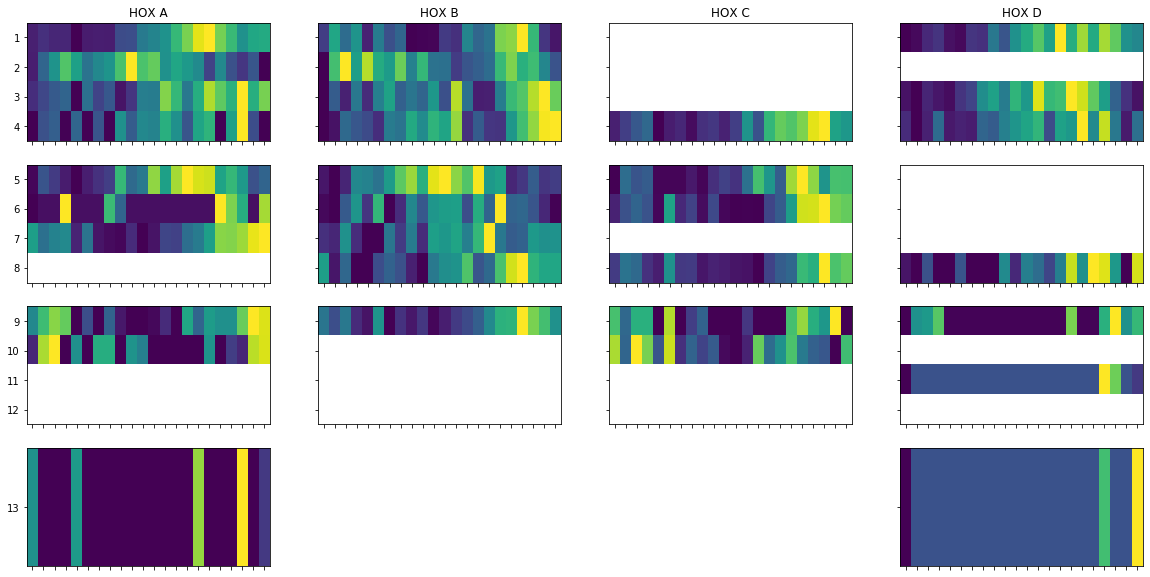

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(441)
plt.imshow(scalezscore(xdf_chi.loc[hoxa14]), aspect = 'auto')
plt.yticks(range(4), range(1,5))
plt.xticks(range(len(xdf_chi.columns)), '')
plt.title('HOX A')

plt.subplot(442)
plt.imshow(scalezscore(xdf_chi.loc[hoxb14]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')
plt.title('HOX B')

plt.subplot(443)
plt.imshow(scalezscore(xdf_chi.loc[hoxc14]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')
plt.title('HOX C')

plt.subplot(444)
plt.imshow(scalezscore(xdf_chi.loc[hoxd14]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')
plt.title('HOX D')

plt.subplot(445)
plt.imshow(scalezscore(xdf_chi.loc[hoxa58]), aspect = 'auto')
plt.yticks(range(4), range(5,9))
plt.xticks(range(len(xdf_chi.columns)), '')

plt.subplot(446)
plt.imshow(scalezscore(xdf_chi.loc[hoxb58]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')

plt.subplot(447)
plt.imshow(scalezscore(xdf_chi.loc[hoxc58]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')

plt.subplot(448)
plt.imshow(scalezscore(xdf_chi.loc[hoxd58]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')

plt.subplot(449)
plt.imshow(scalezscore(xdf_chi.loc[hoxa912]), aspect = 'auto')
plt.yticks(range(4), range(9,13))
plt.xticks(range(len(xdf_chi.columns)), '')

plt.subplot(4,4,10)
plt.imshow(scalezscore(xdf_chi.loc[hoxb912]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')

plt.subplot(4,4,11)
plt.imshow(scalezscore(xdf_chi.loc[hoxc912]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')

plt.subplot(4,4,12)
plt.imshow(scalezscore(xdf_chi.loc[hoxd912]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_chi.columns)), '')

plt.subplot(4,4,13)
plt.imshow(scalezscore(xdf_chi.loc[hoxa13]), aspect = 'auto')
plt.yticks([0], [13])
plt.xticks(range(len(xdf_chi.columns)), '')


plt.subplot(4,4,16)
plt.imshow(scalezscore(xdf_chi.loc[hoxd13]), aspect = 'auto')
plt.yticks([0], '')
plt.xticks(range(len(xdf_chi.columns)), '')

#plt.savefig('../results_postRevJan19/HOX_Chi.pdf', bbox_inches = 'tight')

plt.show()

In [29]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/fig2f.xlsx')

hoxes = [v for v in hoxa14+hoxb14+hoxc14+hoxd14+hoxa58+hoxb58+hoxc58+hoxd58+hoxa912+hoxb912+hoxc912+hoxd912+hoxa13+hoxd13 if len(v) > 0]

xdf_chi.loc[hoxes].to_excel(writer, sheet_name = 'z-score, hoxes')


writer.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


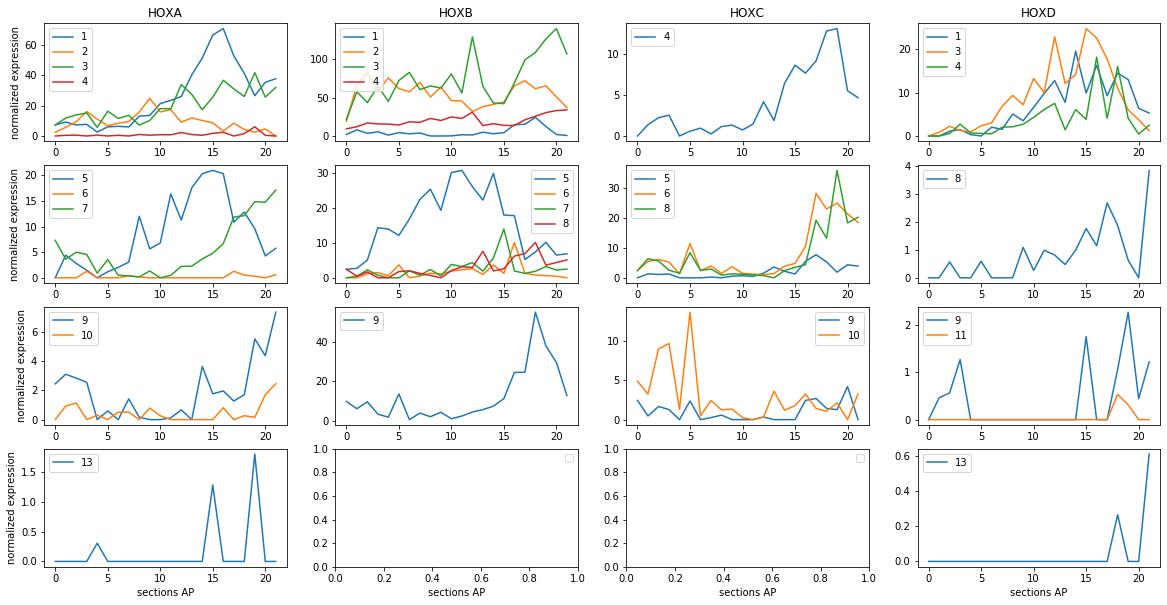

In [41]:
plt.figure(figsize=(20,10))

for n, genes in enumerate([hoxa14, hoxb14, hoxc14, hoxd14, hoxa58, hoxb58, hoxc58, hoxd58, hoxa912, hoxb912, hoxc912, hoxd912, hoxa13, hoxb13, hoxc13, hoxd13]):
    plt.subplot(4,4,n+1)
    for i, hox in enumerate(genes):
        if hox in tdf_chi.index:
            plt.plot(tdf_chi.loc[hox].index, tdf_chi.loc[hox], label = hox.rsplit('HOX')[1].rsplit('__')[0][1:])
        if n == 0:
            plt.title('HOXA')
        if n == 1:
            plt.title('HOXB')
        if n == 2:
            plt.title('HOXC')
        if n == 3:
            plt.title('HOXD')
        if n in [0,4,8,12]:
            plt.ylabel('normalized expression')
        if n in [12,13,14,15]:
            plt.xlabel('sections AP')
    plt.legend()
    
plt.savefig('../results_postRevJan19/HOX_Chi_lineplots.pdf', bbox_inches = 'tight')

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


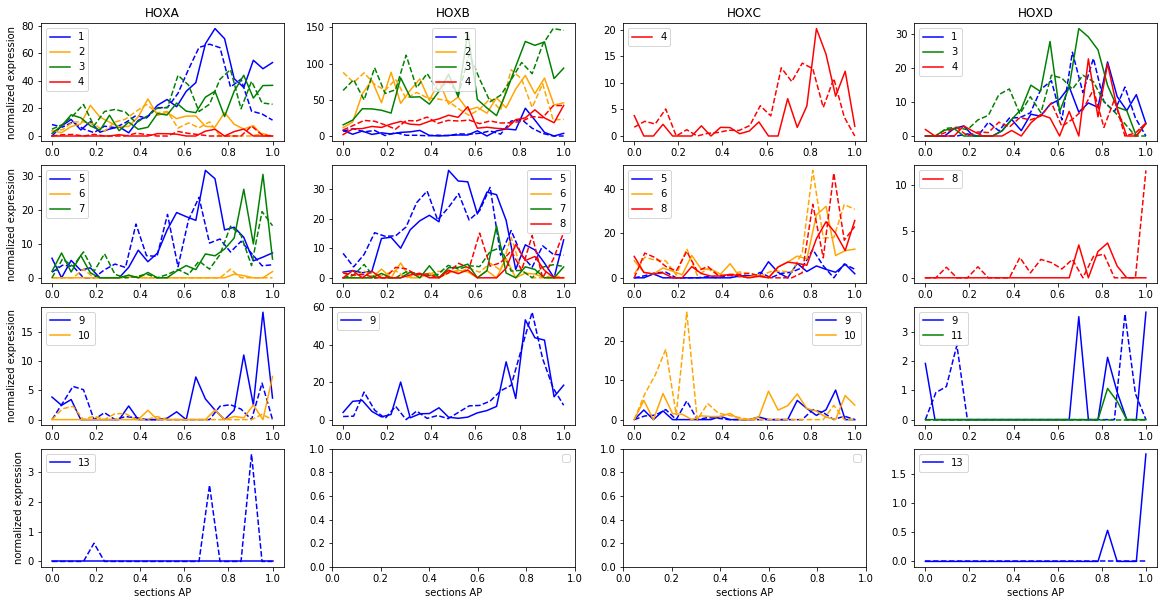

In [55]:
plt.figure(figsize=(20,10))

colors = ['b','orange','green','red']
for n, genes in enumerate([hoxa14, hoxb14, hoxc14, hoxd14, hoxa58, hoxb58, hoxc58, hoxd58, hoxa912, hoxb912, hoxc912, hoxd912, hoxa13, hoxb13, hoxc13, hoxd13]):
    plt.subplot(4,4,n+1)
    for i, hox in enumerate(genes):
        if hox in tdf_chi.index:
            plt.plot(np.linspace(0,1,len(ndfs_chi[0].columns)), ndfs_chi[0].loc[hox], label = hox.rsplit('HOX')[1].rsplit('__')[0][1:], color = colors[i], ls = '-')
            plt.plot(np.linspace(0,1,len(ndfs_chi[1].columns)), ndfs_chi[1].loc[hox], label = '_nolabel_', color = colors[i], ls = '--')
        if n == 0:
            plt.title('HOXA')
        if n == 1:
            plt.title('HOXB')
        if n == 2:
            plt.title('HOXC')
        if n == 3:
            plt.title('HOXD')
        if n in [0,4,8,12]:
            plt.ylabel('normalized expression')
        if n in [12,13,14,15]:
            plt.xlabel('sections AP')
    plt.legend()
    
plt.savefig('../results_postRevJan19/HOX_Chi_lineplots_samples.pdf', bbox_inches = 'tight')

plt.show()

In [58]:
hoxes = hoxa14+hoxb14+hoxc14+hoxd14+hoxa58+hoxb58+hoxc58+hoxd58+hoxa912+hoxb912+hoxc912+hoxd912+hoxa13+hoxb13+hoxc13+hoxd13

In [61]:
gene_corr_chi.loc[[h for h in hoxes if h != '']].to_csv('../results_postRevJan19/HOX_Chi_pvals.tsv', sep = '\t')

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


# Hox genes in mouse gastruloids

# Hox genes in ChiSB43

In [141]:
hoxa14 = []
for letter, number in zip(['A','A','A','A'],[1,2,3,4]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxa14.append(g[0])
    else:
        hoxa14.append('')
print(hoxa14)

['ENSG00000105991_HOXA1__7', 'ENSG00000105996_HOXA2__7', 'ENSG00000105997_HOXA3__7', 'ENSG00000197576_HOXA4__7']


In [142]:
hoxb14 = []
for letter, number in zip(['B']*4,[1,2,3,4]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxb14.append(g[0])
    else:
        hoxb14.append('')
print(hoxb14)

['ENSG00000120094_HOXB1__17', 'ENSG00000173917_HOXB2__17', 'ENSG00000120093_HOXB3__17', 'ENSG00000182742_HOXB4__17']


In [143]:
hoxc14 = []
for letter, number in zip(['C']*4,[1,2,3,4]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxc14.append(g[0])
    else:
        hoxc14.append('')
print(hoxc14)

['', '', '', 'ENSG00000198353_HOXC4__12']


In [144]:
hoxd14 = []
for letter, number in zip(['D']*4,[1,2,3,4]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxd14.append(g[0])
    else:
        hoxd14.append('')
print(hoxd14)

['ENSG00000128645_HOXD1__2', '', 'ENSG00000128652_HOXD3__2', 'ENSG00000170166_HOXD4__2']


In [145]:
hoxa58 = []
for letter, number in zip(['A']*4,[5,6,7,8]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxa58.append(g[0])
    else:
        hoxa58.append('')
print(hoxa58)

hoxb58 = []
for letter, number in zip(['B']*4,[5,6,7,8]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxb58.append(g[0])
    else:
        hoxb58.append('')
print(hoxb58)

hoxc58 = []
for letter, number in zip(['C']*4,[5,6,7,8]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxc58.append(g[0])
    else:
        hoxc58.append('')
print(hoxc58)

hoxd58 = []
for letter, number in zip(['D']*4,[5,6,7,8]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxd58.append(g[0])
    else:
        hoxd58.append('')
print(hoxd58)

['ENSG00000106004_HOXA5__7', 'ENSG00000106006_HOXA6__7', 'ENSG00000122592_HOXA7__7', '']
['ENSG00000120075_HOXB5__17', 'ENSG00000108511_HOXB6__17', 'ENSG00000260027_HOXB7__17', 'ENSG00000120068_HOXB8__17']
['ENSG00000172789_HOXC5__12', 'ENSG00000197757_HOXC6__12', '', 'ENSG00000037965_HOXC8__12']
['', '', '', 'ENSG00000175879_HOXD8__2']


In [146]:
hoxa13 = []
for letter, number in zip(['A']*4,[13]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxa13.append(g[0])
    else:
        hoxa13.append('')
print(hoxa13)

hoxb13 = []
for letter, number in zip(['B']*4,[13]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxb13.append(g[0])
    else:
        hoxb13.append('')
print(hoxb13)

hoxc13 = []
for letter, number in zip(['C']*4,[13]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxc13.append(g[0])
    else:
        hoxc13.append('')
print(hoxc13)

hoxd13 = []
for letter, number in zip(['D']*4,[13]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxd13.append(g[0])
    else:
        hoxd13.append('')
print(hoxd13)

['ENSG00000106031_HOXA13__7']
['']
['']
['ENSG00000128714_HOXD13__2']


In [147]:
hoxa912 = []
for letter, number in zip(['A']*4,[9,10,11,12]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxa912.append(g[0])
    else:
        hoxa912.append('')
print(hoxa912)

hoxb912 = []
for letter, number in zip(['B']*4,[9,10,11,12]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxb912.append(g[0])
    else:
        hoxb912.append('')
print(hoxb912)

hoxc912 = []
for letter, number in zip(['C']*4,[9,10,11,12]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxc912.append(g[0])
    else:
        hoxc912.append('')
print(hoxc912)

hoxd912 = []
for letter, number in zip(['D']*4,[9,10,11,12]):
    hox = '_HOX' + letter + str(number) + '_'
    g = [idx for idx in xdf_sb.index if hox in idx]
    if len(g) == 1:
        hoxd912.append(g[0])
    else:
        hoxd912.append('')
print(hoxd912)

['ENSG00000078399_HOXA9__7', 'ENSG00000253293_HOXA10__7', 'ENSG00000005073_HOXA11__7', '']
['ENSG00000170689_HOXB9__17', '', '', '']
['ENSG00000180806_HOXC9__12', 'ENSG00000180818_HOXC10__12', '', '']
['ENSG00000128709_HOXD9__2', 'ENSG00000128710_HOXD10__2', '', '']


/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentat

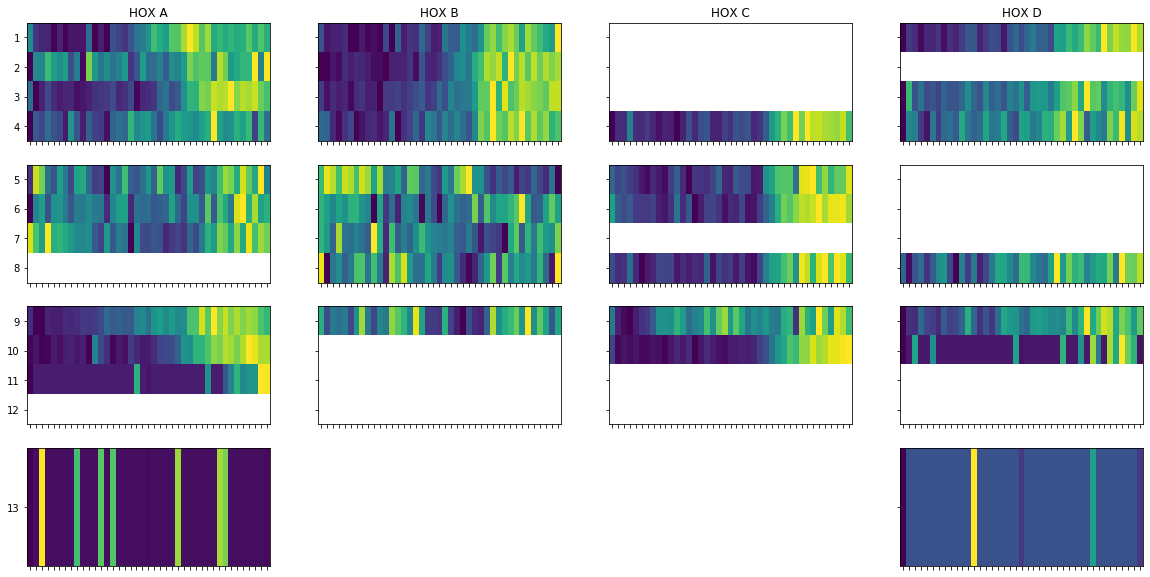

In [148]:
plt.figure(figsize=(20,10))
plt.subplot(441)
plt.imshow(scalezscore(xdf_sb.loc[hoxa14]), aspect = 'auto')
plt.yticks(range(4), range(1,5))
plt.xticks(range(len(xdf_sb.columns)), '')
plt.title('HOX A')

plt.subplot(442)
plt.imshow(scalezscore(xdf_sb.loc[hoxb14]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')
plt.title('HOX B')

plt.subplot(443)
plt.imshow(scalezscore(xdf_sb.loc[hoxc14]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')
plt.title('HOX C')

plt.subplot(444)
plt.imshow(scalezscore(xdf_sb.loc[hoxd14]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')
plt.title('HOX D')

plt.subplot(445)
plt.imshow(scalezscore(xdf_sb.loc[hoxa58]), aspect = 'auto')
plt.yticks(range(4), range(5,9))
plt.xticks(range(len(xdf_sb.columns)), '')

plt.subplot(446)
plt.imshow(scalezscore(xdf_sb.loc[hoxb58]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')

plt.subplot(447)
plt.imshow(scalezscore(xdf_sb.loc[hoxc58]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')

plt.subplot(448)
plt.imshow(scalezscore(xdf_sb.loc[hoxd58]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')

plt.subplot(449)
plt.imshow(scalezscore(xdf_sb.loc[hoxa912]), aspect = 'auto')
plt.yticks(range(4), range(9,13))
plt.xticks(range(len(xdf_sb.columns)), '')

plt.subplot(4,4,10)
plt.imshow(scalezscore(xdf_sb.loc[hoxb912]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')

plt.subplot(4,4,11)
plt.imshow(scalezscore(xdf_sb.loc[hoxc912]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')

plt.subplot(4,4,12)
plt.imshow(scalezscore(xdf_sb.loc[hoxd912]), aspect = 'auto')
plt.yticks(range(4), '')
plt.xticks(range(len(xdf_sb.columns)), '')

plt.subplot(4,4,13)
plt.imshow(scalezscore(xdf_sb.loc[hoxa13]), aspect = 'auto')
plt.yticks([0], [13])
plt.xticks(range(len(xdf_sb.columns)), '')


plt.subplot(4,4,16)
plt.imshow(scalezscore(xdf_sb.loc[hoxd13]), aspect = 'auto')
plt.yticks([0], '')
plt.xticks(range(len(xdf_sb.columns)), '')

plt.savefig('../results_postRevJan19/HOX_ChiSB43.pdf', bbox_inches = 'tight')

plt.show()

# Differential gene expression analysis

In [77]:
n10nfdfsChi = [1e5*df/df.sum().sum() for df in nfdfsChi]
n10nfdfsSB = [1e5*df/df.sum().sum() for df in nfdfsSB]

In [78]:
dex_Chi = pd.DataFrame({
    'total-rep1': n10nfdfsChi[0].sum(axis=1),
    'total-rep2': n10nfdfsChi[1].sum(axis=1),
    'total-mean': {idx: np.mean(list(n10nfdfsChi[0].loc[idx].values) + list(n10nfdfsChi[1].loc[idx].values)) for idx in set(list(n10nfdfsChi[0].index)+list(n10nfdfsChi[1].index)) if idx in n10nfdfsChi[0].index and idx in n10nfdfsChi[1].index}
})

In [79]:
dex_SB = pd.DataFrame({
    'total-rep1': n10nfdfsSB[0].sum(axis=1),
    'total-rep2': n10nfdfsSB[1].sum(axis=1),
    'total-mean': {idx: np.mean(list(n10nfdfsSB[0].loc[idx].values) + list(n10nfdfsSB[1].loc[idx].values)) for idx in set(list(n10nfdfsSB[0].index)+list(n10nfdfsSB[1].index)) if idx in n10nfdfsSB[0].index and idx in n10nfdfsSB[1].index}
})

In [80]:
dex_Chi['log2FC'] = np.log2(dex_Chi['total-rep1']/dex_Chi['total-rep2'])
dex_Chi['log2mu'] = np.log2(0.5*(dex_Chi['total-rep1']+dex_Chi['total-rep2'])) # np.log2(dex_Chi['total-mean'])

dex_SB['log2FC'] = np.log2(dex_SB['total-rep1']/dex_SB['total-rep2'])
dex_SB['log2mu'] = np.log2(0.5*(dex_SB['total-rep1']+dex_SB['total-rep2'])) # np.log2(dex_SB['total-mean'])

In [81]:
dex_Chi['prob-rep1'] = dex_Chi['total-rep1']/dex_Chi['total-rep1'].sum()
dex_Chi['prob-rep2'] = dex_Chi['total-rep2']/dex_Chi['total-rep2'].sum()

dex_Chi['N1'] = dex_Chi['total-rep1'].sum()
dex_Chi['N2'] = dex_Chi['total-rep2'].sum()

dex_Chi.head()

,total-rep1,total-rep2,total-mean,log2FC,log2mu,prob-rep1,prob-rep2,N1,N2
ENSG00000000003_TSPAN6__X,48.501303,46.313279,2.061187,0.066598,5.567037,0.000485,0.000463,100000.0,100000.0
ENSG00000000005_TNMD__X,0.390942,0.397142,0.017132,-0.022700,-1.343579,0.000004,0.000004,100000.0,100000.0
ENSG00000000419_DPM1__20,9.348098,9.358565,0.406667,-0.001614,3.225480,0.000093,0.000094,100000.0,100000.0
ENSG00000000457_SCYL3__1,3.589290,3.131557,0.146105,0.196818,1.748643,0.000036,0.000031,100000.0,100000.0
ENSG00000000460_C1orf112__1,2.054092,1.491320,0.077074,0.461911,0.825954,0.000021,0.000015,100000.0,100000.0


In [82]:
dex_SB['prob-rep1'] = dex_SB['total-rep1']/dex_SB['total-rep1'].sum()
dex_SB['prob-rep2'] = dex_SB['total-rep2']/dex_SB['total-rep2'].sum()

dex_SB['N1'] = dex_SB['total-rep1'].sum()
dex_SB['N2'] = dex_SB['total-rep2'].sum()

In [83]:
fdex_Chi = dex_Chi.loc[gl_chi]
fdex_SB = dex_SB.loc[gl_SB]

In [84]:
from scipy.stats import binom

In [85]:
def dex_Pval(expression, total, prob):
    expression, total = int(expression), int(total)
    pv = binom.cdf(expression, total, prob)
    if pv > 0.5:
        pv = 1-pv
    return pv

In [86]:
fdex_Chi['Pval1'] = fdex_Chi.apply(lambda x: dex_Pval(x['total-rep1'],x['N1'],x['prob-rep2']), axis = 1)
fdex_Chi['Pval2'] = fdex_Chi.apply(lambda x: dex_Pval(x['total-rep2'],x['N2'],x['prob-rep1']), axis = 1)

In [87]:
fdex_SB['Pval1'] = fdex_SB.apply(lambda x: dex_Pval(x['total-rep1'],x['N1'],x['prob-rep2']), axis = 1)
fdex_SB['Pval2'] = fdex_SB.apply(lambda x: dex_Pval(x['total-rep2'],x['N2'],x['prob-rep1']), axis = 1)

In [88]:
fdex_SB[['total-rep1','total-rep2','log2mu','log2FC','Pval1']].to_csv('../results_postRevJan19/comparison_chi_chisb43/dex_ChiSB43.tsv', sep = '\t')
fdex_Chi[['total-rep1','total-rep2','log2mu','log2FC','Pval1']].to_csv('../results_postRevJan19/comparison_chi_chisb43/dex_Chi.tsv', sep = '\t')

In [89]:
fdex_SB.head()

,total-rep1,total-rep2,total-mean,log2FC,log2mu,prob-rep1,prob-rep2,N1,N2,Pval1,Pval2
ENSG00000000003_TSPAN6__X,48.874863,53.404089,1.203282,-0.127858,5.676365,0.000489,0.000534,100000.0,100000.0,0.255059,0.249748
ENSG00000001630_CYP51A1__7,29.558585,41.616919,0.837359,-0.493593,5.153309,0.000296,0.000416,100000.0,100000.0,0.025256,0.017938
ENSG00000004478_FKBP4__12,26.093468,26.177869,0.614957,-0.004659,4.707948,0.000261,0.000262,100000.0,100000.0,0.461946,0.455366
ENSG00000005020_SKAP2__7,16.846749,19.983007,0.433291,-0.246303,4.202800,0.000168,0.000200,100000.0,100000.0,0.222160,0.251296
ENSG00000005102_MEOX1__17,3.862211,3.967794,0.092118,-0.038910,1.969013,0.000039,0.000040,100000.0,100000.0,0.439791,0.460846


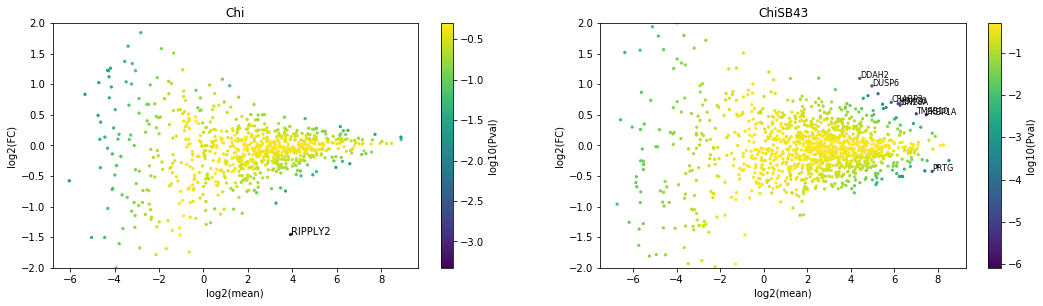

In [90]:
plt.figure(figsize=(12*1.5,3*1.5))

plt.subplot(121)
plt.scatter(fdex_Chi['log2mu'], fdex_Chi['log2FC'], s = 5, c = np.log10(fdex_Chi['Pval1']))
plt.colorbar(label = 'log10(Pval)')
for g in fdex_Chi[np.log10(fdex_Chi['Pval1'])<-3].index:
    x = fdex_Chi.loc[g,'log2mu']
    y = fdex_Chi.loc[g,'log2FC']
    plt.text(x, y, g.rsplit('_')[1])
plt.title('Chi')
plt.xlabel('log2(mean)')
plt.ylabel('log2(FC)')
plt.ylim(-2,2)

plt.subplot(122)
plt.scatter(fdex_SB['log2mu'], fdex_SB['log2FC'], s = 5, c = np.log10(fdex_SB['Pval1']))
for g in fdex_SB[np.log10(fdex_SB['Pval1'])<-4].index:
    x = fdex_SB.loc[g,'log2mu']
    y = fdex_SB.loc[g,'log2FC']
    plt.text(x, y, g.rsplit('_')[1], fontsize = 8)
plt.colorbar(label = 'log10(Pval)')
plt.title('ChiSB43')
plt.xlabel('log2(mean)')
plt.ylabel('log2(FC)')
plt.ylim(-2,2)

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/dex_chi_chiSB43_independently.pdf', bbox_inches = 'tight')
plt.show()

In [91]:
fdex_Chi.to

AttributeError: 'DataFrame' object has no attribute 'to'

In [ ]:
fdex_Chi[np.log10(fdex_Chi['Pval1'])<-3].index

In [ ]:
fdex_SB[np.log10(fdex_SB['Pval1'])<-4].index

In [ ]:
fdex_Chi.columns = [c + '-chi' for c in fdex_Chi.columns]
fdex_SB.columns = [c + '-sb' for c in fdex_SB.columns]

In [ ]:
fdex_chichisb = fdex_Chi.merge(fdex_SB, how = 'inner', left_index = True, right_index = True)
# or:
# fdex_chichisb = fdex_Chi.merge(fdex_SB, how = 'outer', left_index = True, right_index = True)
# fdex_chichisb = fdex_chichisb.fillna(0)
# for c in ['N1-chi','N2-chi','N1-sb, N2-sb']:
#     fdex_chichisb[c] = 100000.0
# for c in ['total-rep1-chi','total-rep2-chi','total-rep1-sb','total-rep2-sb']:
#     fdex_chichisb[c] = [1e-4 if fdex_chichisb.loc[idx,c]==0 else fdex_chichisb.loc[idx,c] for idx in fdex_chichisb.index] 

In [ ]:
fdex_chichisb.head()

In [ ]:
fdex_chichisb['mean-chi'] = 0.5*(fdex_chichisb['total-rep1-chi']+fdex_chichisb['total-rep2-chi'])
fdex_chichisb['mean-sb'] = 0.5*(fdex_chichisb['total-rep1-sb']+fdex_chichisb['total-rep2-sb'])
fdex_chichisb['mean'] = 0.5*(fdex_chichisb['mean-chi']+fdex_chichisb['mean-sb'])
fdex_chichisb['FC-chisb'] = fdex_chichisb['mean-chi']/fdex_chichisb['mean-sb']

fdex_chichisb['prob-chi'] = fdex_chichisb['mean-chi']/1e5
fdex_chichisb['prob-sb'] = fdex_chichisb['mean-sb']/1e5

fdex_chichisb['log-mean'] = np.log2(fdex_chichisb['mean'])
fdex_chichisb['log-FC-chisb'] = np.log2(fdex_chichisb['FC-chisb'])

In [ ]:
fdex_chichisb.head()

In [ ]:
fdex_chichisb['Pval-chi'] = fdex_chichisb.apply(lambda x: dex_Pval(x['mean-chi'],100000,x['prob-sb']), axis = 1)
fdex_chichisb['Pval-sb'] = fdex_chichisb.apply(lambda x: dex_Pval(x['mean-sb'],100000,x['prob-chi']), axis = 1)

In [ ]:
fdex_chichisb[['mean-chi','mean-sb','FC-chisb','Pval-chi','Pval-sb']].to_csv('../results_postRevJan19/comparison_chi_chisb43/dex_chiVSchisb43.tsv', sep = '\t')

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(fdex_chichisb['log-mean'], fdex_chichisb['log-FC-chisb'], c = np.log10(fdex_chichisb['Pval-chi']), vmin = -10)
plt.colorbar(label = 'log10(P-val)', shrink = 0.5)

for g in fdex_chichisb[np.log10(fdex_chichisb['Pval-chi'])<-7].index:
    x = fdex_chichisb.loc[g,'log-mean']+0.05
    y = fdex_chichisb.loc[g,'log-FC-chisb']+0.05
    plt.text(x, y, g.rsplit('_')[1], fontsize = 8)

plt.xlabel('log2(mean)')
plt.ylabel('log2(FC (chi/chiSB43))')
plt.savefig('../results_postRevJan19/comparison_chi_chisb43/dex_chiVSchiSB43.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
genes = fdex_chichisb[(np.log10(fdex_chichisb['Pval-chi'])<-7)&(fdex_chichisb['log-FC-chisb']>0)].index
for i, g in enumerate(genes):
    plt.subplot(4,5,i+1)
    for j, df in enumerate(nfdfsChi):
        if j == 0:
            plt.plot(range(len(df.columns)), df.loc[g], c = 'b', label = 'Chi')
        else:
            plt.plot(range(len(df.columns)), df.loc[g], c = 'b', label = '_nolabel_')
    for j, df in enumerate(nfdfsSB):
        if j == 0:
            plt.plot(range(len(df.columns)), df.loc[g], c = 'r', label = 'ChiSB43')
        else:
            plt.plot(range(len(df.columns)), df.loc[g], c = 'r', label = '_nolabel_')
    plt.title(g.rsplit('_')[1])
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel('AP sections')
plt.legend(loc = 2, bbox_to_anchor = (1,0.5))

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/dex_chiVSchiSB43_exprUP_chi.pdf', bbox_inches = 'tight')

plt.show()


In [ ]:
plt.figure(figsize=(15,10))
genes = fdex_chichisb[(np.log10(fdex_chichisb['Pval-chi'])<-7)&(fdex_chichisb['log-FC-chisb']<0)].index
for i, g in enumerate(genes):
    plt.subplot(4,5,i+1)
    for j, df in enumerate(nfdfsChi):
        if j == 0:
            plt.plot(range(len(df.columns)), df.loc[g], c = 'b', label = 'Chi')
        else:
            plt.plot(range(len(df.columns)), df.loc[g], c = 'b', label = '_nolabel_')
    for j, df in enumerate(nfdfsSB):
        if j == 0:
            plt.plot(range(len(df.columns)), df.loc[g], c = 'r', label = 'ChiSB43')
        else:
            plt.plot(range(len(df.columns)), df.loc[g], c = 'r', label = '_nolabel_')
    plt.title(g.rsplit('_')[1])
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel('AP sections')
plt.legend(loc = 2, bbox_to_anchor = (1,0.5))

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/dex_chiVSchiSB43_exprUP_chiSB43.pdf', bbox_inches = 'tight')


plt.show()
